
 
<font size = 5><span style="font-family:'Times New Roman'">Notebook Overview : </span></font>

* <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> This notebook contains:  </span></font>
    1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">A Encoder Decoder Model which takes an image as an input and outputs a caption </span></font>
    2. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Encoder used is <a href = "https://huggingface.co/google/vit-base-patch16-224"><b>Vision Transformer </b></a> </span></font>
    3. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Decoder used is <a href = "https://huggingface.co/gpt2"><b>GPT2</b></a></span></font>
    4. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'"> The model is trained on <b>Flickr8k dataset</b></span></font>
    5. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'"> The hugging face <a href = "https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainer"><b>Seq2SeqTrainer</b></a> is used for finetuning the model</span></font>
   
*  <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The hugging face <b> transformers</b> library is used to finetune the model and <b> Pytorch</b> for data processing </span></font>


# TABLE OF CONTENTS

- [1. Imports](#1)
- [2. Hyperparameters](#2)
- [3. Helper Functions](#3)
- [4. Dataset](#4)
  * .[4.1 Feature Extractor and Tokenizer](#4.4)
  * [4.2 Transforms and dataframe](#4.1)
  * [4.3 Dataset Class](#4.2)
  * .[4.4 Train and validation dataset](#4.3)
- [5. Model Building](#5)
    * .[5.1 Model Initialization](#5.2)
- [6. Training](#6)
    * .[6.1 Training Arguments](#6.1)
    * .[6.2 Training using Seq2SeqTrainer](#6.2)
- .[7. Predictions](#7)

In [1]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()


# 1. IMPORTS 📂
#### [Top ↑](#top)

In [2]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

 
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB



# 2. HYPERPARAMETERS
#### [Top ↑](#top)

In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95


# 3. HELPER FUNCTIONS
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> There are Two helper functions:  </span></font>
1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The first function is to <b>build special tokens</b> while tokenizing the captions  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The second function is used to compute the <b>ROUGE-2</b> metrics as we are working with Transformers  </span></font>

In [4]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [5]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }



# 4. DATASET



## 4.1 Feature Extractor and Tokenizer 
#### [Top ↑](#top)

1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The Feature extractor is loaded using <b>ViTFeatureExtractor</b>  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The tokenizer for GPT2 is loaded using the <b>AutoTokenizer</b>  </span></font>

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]


## 4.2 Transforms and dataframe 
#### [Top ↑](#top)

 <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The Transformations used are </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Resizing</b> the image to (224,224) </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Normalizing</b> the image</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> Converting the image to <b>Tensor</b>  </span></font>

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/kaggle/input/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...



## 4.3 Dataset Class 
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The dataset is created using the following steps </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">We read the image using the <b>Image</b> function of PIL library </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The image is <b>transformed</b> using the transformed defined above</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The transformed image is passed through the <b>feature extractor</b> to extract the pixel values from the image </span></font>
4. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The captions are loaded from the dataframe</span></font>
5. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The captions are <b>tokenized</b></span></font>
6. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The tokenized captions are <b>padded</b> to max length</span></font>
7. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The images and tokenized captions are returned</span></font>

In [8]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        


## 4.4 Train and validation dataset:
#### [Top ↑](#top)

In [9]:
train_dataset = ImgDataset(train_df, root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)


# 5. MODEL BUILDING

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">ENCODER</p>
<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</span></font>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">DECODER</p>
<br> 

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</span></font>
    
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</span></font>
    


## 5.1 Model Initialization 
#### [Top ↑](#top)

In [10]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.ln_cross_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.6.crossattention.c_attn.weight', 'h.8.ln_cross_attn.weight', 'h.5.crossattention.c_proj.weight', 'h.0.crossattention.masked_bias', 'h.11.crossattention.q_attn.weight', 'h.1.ln_cross_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.4.crossattention.c_attn.weight', 'h.8.crossattention.c_attn.weight', 'h.2.crossattention.c_attn.weight', 'h.5.crossattention.c_proj.bias', 'h.5.crossattention.masked_bias', 'h.7.crossattention.masked_bias', 'h.5.crossattention.c_attn.weight', 'h.10.crossattention.bias', 'h.11.crossattention.c_attn.weight', 'h.10.crossattention.masked_bias', 'h.5.ln_cross_attn.weight', 'h.9.ln_cross_attn.weight', 'h.9.crossattention.c_proj.bias', 'h.3.ln_cross_attn.weight', 'h.10.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.weight', 'h.8.crossatt

In [11]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


# 6. TRAINING

<a id="6.1"></a>
## 6.1 Training Arguments 
#### [Top ↑](#top)

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



## 6.2 Training using Seq2SeqTrainer
#### [Top ↑](#top)

In [13]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32364
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12138


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,2.632400,2.409627,0.028300,0.277700,0.050500
2,2.143200,2.242059,0.032900,0.305400,0.057700
3,1.799000,2.220979,0.033100,0.317000,0.058400


Saving model checkpoint to VIT_large_gpt2/checkpoint-2048
Configuration saved in VIT_large_gpt2/checkpoint-2048/config.json
Model weights saved in VIT_large_gpt2/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8091
  Batch size = 8
Saving model checkpoint to VIT_large_gpt2/checkpoint-4096
Configuration saved in VIT_large_gpt2/checkpoint-4096/config.json
Model weights saved in VIT_large_gpt2/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_large_gpt2/checkpoint-2048] due to args.save_total_limit
Saving model checkpoint to VIT_large_gpt2/checkpoint-6144
Configuration saved in VIT_large_gpt2/checkpoint-6144/config.json
Model weights saved in VIT_large_gpt2/checkpoint-6144/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-6144/preprocessor_config.json
Delet

TrainOutput(global_step=12138, training_loss=2.2742231126710797, metrics={'train_runtime': 23572.7081, 'train_samples_per_second': 4.119, 'train_steps_per_second': 0.515, 'total_flos': 1.7521600116635468e+19, 'train_loss': 2.2742231126710797, 'epoch': 3.0})

In [14]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json



# 7. PREDICTIONS

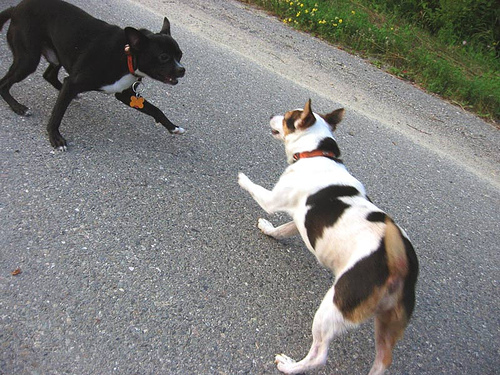

In [15]:
img =  Image.open("/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [16]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

<|endoftext|>A black dog and a white dog are running on the sidewalk. A black dog is 


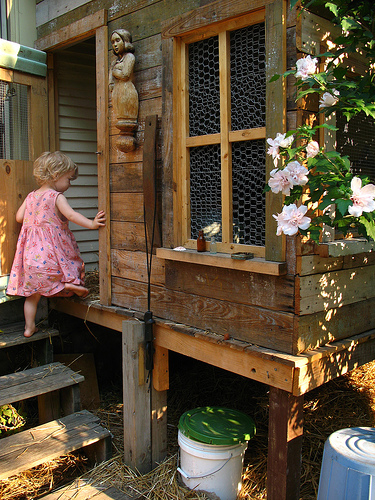

In [17]:
img =  Image.open("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [18]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A little girl in a pink dress is standing by a wooden door in a wooded area. Another little girl is peeking


# 8. Loader
#### [Top ↑](#top)

In [29]:
import os

print(os.listdir("/kaggle/input/dataloader/VIT_large_gpt2"))


['runs', 'config.json', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'checkpoint-10240']


In [30]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2Tokenizer

model_dir = "/kaggle/input/dataloader/VIT_large_gpt2"

# Load lại model
model = VisionEncoderDecoderModel.from_pretrained(model_dir)

# Dùng lại tokenizer gốc GPT2 vì bạn không save nó
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # cần thiết nếu bạn đã dùng pad = eos khi train
model.config.pad_token_id = tokenizer.pad_token_id

# Load feature extractor từ thư mục đã save
feature_extractor = ViTImageProcessor.from_pretrained(model_dir)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "1

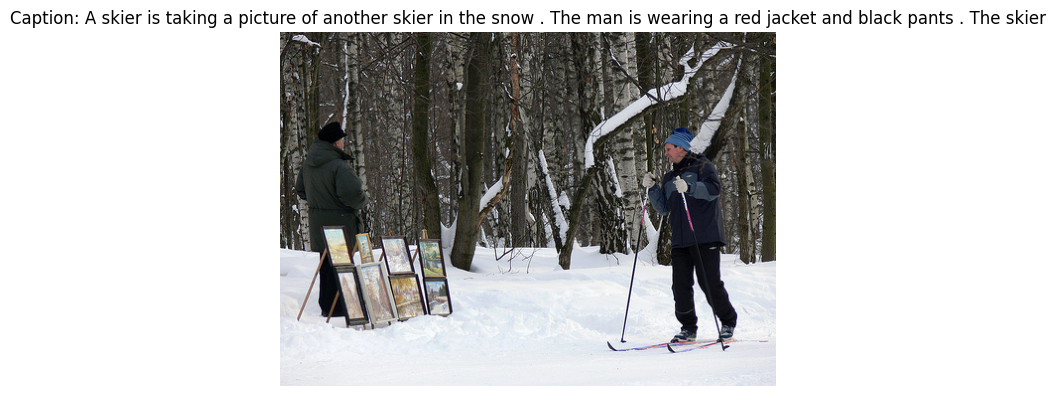

A skier is taking a picture of another skier in the snow . The man is wearing a red jacket and black pants . The skier


In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load ảnh
image_path = "/kaggle/input/flickr8k/Images/101669240_b2d3e7f17b.jpg"
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

# Sinh caption
output_ids = model.generate(pixel_values, max_length=30, num_beams=4)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Hiển thị ảnh và caption
plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()
print(caption)

In [1]:
!pip install sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00


In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import sacrebleu

# Thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [33]:
# Load ảnh test
image_path = "/kaggle/input/testanh123/Screenshot 2025-05-04 212959.png"
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

# Sinh caption
output_ids = model.generate(pixel_values, max_length=30, num_beams=4)
generated_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)


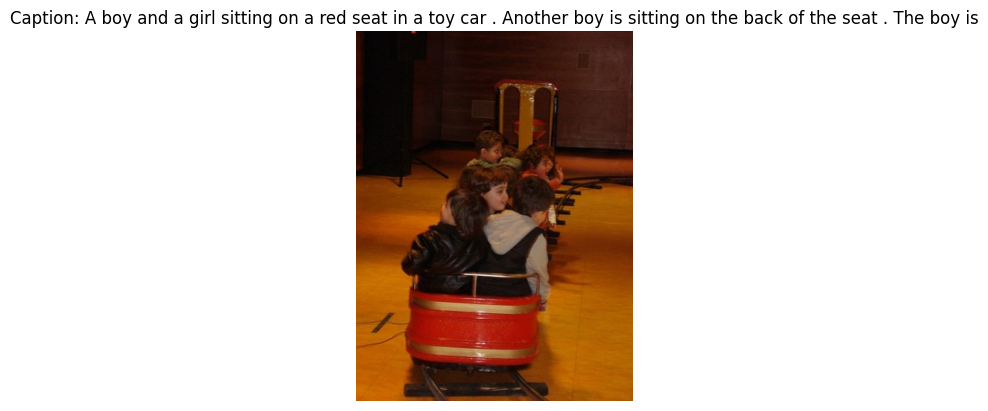

Generated Caption: A boy and a girl sitting on a red seat in a toy car . Another boy is sitting on the back of the seat . The boy is
Reference Caption: some children are riding on a mini orange train
BLEU (SacreBLEU) - Caption: 2.5734


In [34]:
# Ground truth caption
reference_caption = "some children are riding on a mini orange train"

# SacreBLEU expects list of references and hypothesis
bleu_sacre = sacrebleu.corpus_bleu([generated_caption], [[reference_caption]]).score
plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {generated_caption}", fontsize=12)
plt.show()

print("Generated Caption:", generated_caption)
print("Reference Caption:", reference_caption)
print(f"BLEU (SacreBLEU) - Caption: {bleu_sacre:.4f}")


In [35]:
!pip install -q sentence-transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

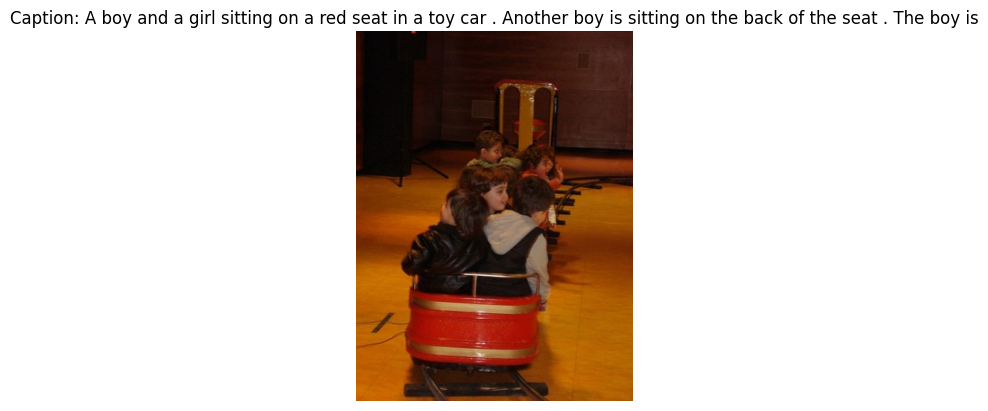

Generated Caption: A boy and a girl sitting on a red seat in a toy car . Another boy is sitting on the back of the seat . The boy is
Reference Caption: some children are riding on a mini orange train
Similarity: 0.3914


In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util

# Chuyển mô hình sang GPU nếu có
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load ảnh
image_path = "/kaggle/input/testanh123/Screenshot 2025-05-04 212959.png"
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

# Sinh caption
output_ids = model.generate(pixel_values, max_length=30, num_beams=4)
generated_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Caption gốc (ground truth)
reference_caption = "some children are riding on a mini orange train"

# Tính độ tương đồng bằng Sentence-BERT
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding1 = sbert_model.encode(generated_caption, convert_to_tensor=True)
embedding2 = sbert_model.encode(reference_caption, convert_to_tensor=True)

similarity = util.pytorch_cos_sim(embedding1, embedding2)

# Hiển thị ảnh và caption
plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {generated_caption}", fontsize=12)
plt.show()

# In kết quả
print("Generated Caption:", generated_caption)
print("Reference Caption:", reference_caption)
print(f"Similarity: {similarity.item():.4f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

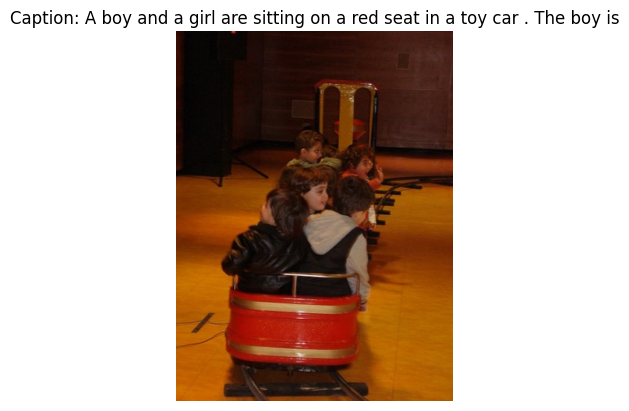

Generated Caption: A boy and a girl are sitting on a red seat in a toy car . The boy is
Reference Caption: some children are riding on a mini orange train
Similarity: 0.3817


In [37]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util

# Chuyển mô hình sang GPU nếu có
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load ảnh
image_path = "/kaggle/input/testanh123/Screenshot 2025-05-04 212959.png"
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

# Sinh caption với độ dài giới hạn
output_ids = model.generate(
    pixel_values,
    max_length=20,         # Giới hạn caption ngắn hơn
    num_beams=4,
    no_repeat_ngram_size=4,
    early_stopping=True
)

generated_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Caption gốc (ground truth)
reference_caption = "some children are riding on a mini orange train"

# Tính độ tương đồng bằng Sentence-BERT
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding1 = sbert_model.encode(generated_caption, convert_to_tensor=True)
embedding2 = sbert_model.encode(reference_caption, convert_to_tensor=True)

similarity = util.pytorch_cos_sim(embedding1, embedding2)

# Hiển thị ảnh và caption
plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {generated_caption}", fontsize=12)
plt.show()

# In kết quả
print("Generated Caption:", generated_caption)
print("Reference Caption:", reference_caption)
print(f"Similarity: {similarity.item():.4f}")
